In [188]:
import numpy as np
import pandas as pd
import logging as log

from IPython.display import display

import plotly
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
plotly.plotly.sign_in('spersad', 'MwbO3xbqh2Mv6sfhCma7')
import plotly.graph_objs as go

log.getLogger().setLevel(log.INFO)

import tensorflow as tf

### Simulate binary vectors

In [189]:
def simulate_clusters(nclusters, readLength, nreads=10000, probs = None, pi=None, independent = True):
    ''' Simulate a mixture of multivariable Bernoulli random variables as binary vectors
        @param: nclusters - the number of clusters to generate
        @param: readLength - the length of a multivaribable R.V.
        @param: nreads - the number of reads to sample
        @param: probs - an (optional) list of probability distributions. Must be of length nclusters, and probs[0]
                        must have length readLength
        @param: pi - the mixing proportions of each cluster. Must be of length nclusters
        @param: independent - if this is true, positions are independent of each other. 
                              Experimentally we find that if there is a mutation at a position, there can be no mutations 
                              within three bases.
        @return: bitvector -  an array of binary vectors
    '''
    
    if probs != None:
        if len(pi) != nclusters:
            log.error('There is an incorrect number of mixing proportions')
        if len(probs) != nclusters:
            log.error('There is an incorrect number of probability distributions')
            return
        for dist in probs:
            if len(dist) != readLength:
                log.error('The distribution length {0} does not match the read length {1}'.format(len(dist),readLength))
                return 
    else:
        # Randomly generate probability distributions 
        pass 
    
    # Randomly generate binary vectors based on distributions specified

    
    bitvectors = []
    labels = []
    for k in range(nclusters):
        dist = probs[k]
        for j in range(int(nreads*pi[k])):
            x = np.array([np.random.binomial(1,p) for p in dist])
            if not independent:
                for i in range(len(x)-3):
                    if x[i]==1:
                        x[i+1:i+3]=0 # zero out everyone within a distance of three
            if x.sum()>2:
                bitvectors.append(x)
                labels.append(k)

        
    # Do some final processing to reshape as needed
    bitvectors = np.array(bitvectors)
    labels = np.array(labels)
    
    p = np.random.permutation(len(labels))
    
    return bitvectors[p], labels[p], probs, pi
        

In [190]:
def load_bitvectors(path, sep='\t'):
    '''
    Given a pandas dataframe with headings Read_name Binary_vector N_mutations Reference_name Start_position
    load only the bitvectors as a numpy array of integers
    @param: path - path to bitvector file
    @return: bitreads - an array of bitvectors
    '''
    bitvectors=pd.read_csv(path,sep=sep)
    #Grab the bit vectors only 
    bitreads = bitvectors.as_matrix(columns=['Binary_vector'])
    log.debug("bitreads[0][0]=%s" % ( bitreads[0][0]))
    len_bits = str(len(list(bitreads[0][0])))
    log.debug("Len bits is %s" % len_bits)
    size = bitreads.size
    bitreads = np.array(bitreads,dtype='|S'+len_bits)
    bitreads = bitreads.view('S1')
    bitreads = bitreads.reshape((size, -1))
    bitreads = bitreads.astype('|S4')
    bitreads[bitreads == '?'] = 0    
    bitreads = bitreads.astype(np.float)

    
    return bitreads


def denoise_bitvectors(bitvectors, threshold=0.001):
    '''
    Given an array of bitvectors, zero out all columns where the population average is below the given threshold.
    @param: bitvectors - numpy array of bitvectors
    @param: decimal threshold below which entries are considered noise. Default to 0.001=1%
    
    @return: denoised_bitvectors - numpy array of bitvectors where low signal positions are zero-ed out.'''
    population_average = bitvectors.sum(axis=0)/bitvectors.shape[1]
    denoise = np.where(population_average<threshold)
    bitvectors[:,denoise] = 0
    
    return bitvectors
    
    
def load_oligo(path):
    '''
    Given a pandas dataframe with headings Read_name Binary_vector N_mutations Reference_name Start_position
    load only the bitvectors as a numpy array of integers
    @param: path - path to bitvector file
    @return: bitreads - an array of bitvectors
    '''
    bitvectors=pd.read_csv(path,sep='\t')
    print(bitvectors.head())
#     bitvectors = bitvectors[bitvectors['N_mutations'] > 1]
    #Grab the bit vectors only 
    bitreads = bitvectors.as_matrix(columns=['Binary_vector'])
    text = bitreads
    labels = bitvectors['Reference_name']
    labels[labels=='oligo'] = -1
    labels[labels=='no_oligo'] = 1
    log.debug("bitreads[0][0]=%s" % ( bitreads[0][0]))
    len_bits = str(len(list(bitreads[0][0])))
    log.debug("Len bits is %s" % len_bits)
    size = bitreads.size
    bitreads = np.array(bitreads,dtype='|S'+len_bits)
    bitreads = bitreads.view('S1')
    bitreads = bitreads.reshape((size, -1))
    bitreads = bitreads.astype('|S4')
    bitreads[bitreads == '?'] = 0    
    bitreads = bitreads.astype(np.float)
    
    idx = np.sum(bitreads, axis=1) > 5 # only allow sufficient mutations
    bitreads = bitreads[idx] 
    labels = labels[idx]
    text = text[idx]
    p = np.random.permutation(len(labels))
    
    return bitreads[p], labels[p], text[p]




In [191]:

l_12=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0.2, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0.005, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.15, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0.00, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0.15, 0, 0.5, 0.3, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0.5, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0.3, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0])
l_11=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0.00, 0.45, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0.4, 0, 0, 0.2, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.3, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0])

l_22=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0.2, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0.15, 0, 0.3, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.15, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0.15, 0, 0.5, 0.3, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0.5, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0.3, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0])
l_21=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.15, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0.4, 0, 0, 0.2, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.3, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0])

probs_1=[l_11,l_12]
pi_1 = [0.3,0.7]

probs_2 = [l_21,l_22]
pi_2 = [0.3,0.7]

probs_3 = [l_11/3, l_12/4]
pi_3 = pi_1

probs_4 = [l_21/3, l_22/4]
pi_4=pi_2

simX1, simY1, _,_, = simulate_clusters(nclusters=2, readLength=400, nreads=50000, probs=probs_1, pi=pi_1, independent=False)
simX1 = denoise_bitvectors(simX1)
log.info('Generated clusters on sample 1.')

simX2, simY2, _,_, = simulate_clusters(nclusters=2, readLength=400, nreads=50000, probs=probs_2, pi=pi_2, independent=False)
simX2 = denoise_bitvectors(simX2)
log.info('Generated clusters on sample 2.')

simX3, simY3, _,_, = simulate_clusters(nclusters=2, readLength=400, nreads=50000, probs=probs_3, pi=pi_3, independent=False)
simX3 = denoise_bitvectors(simX3)
log.info('Generated clusters on sample 3.')

simX4, simY4, _,_, = simulate_clusters(nclusters=2, readLength=400, nreads=50000, probs=probs_4, pi=pi_4, independent=False)
simX4 = denoise_bitvectors(simX4)
log.info('Generated clusters on sample 4.')

INFO:root:Generated clusters on sample 1.
INFO:root:Generated clusters on sample 2.
INFO:root:Generated clusters on sample 3.
INFO:root:Generated clusters on sample 4.


In [192]:
def plot_clusters(X, Y, sample='1'):
    ''' Plot the population average as well as individual clusters.'''
    x=[i for i in range(X.shape[1])]
    y=100*X.sum(axis=0)/X.shape[0]

    trace = go.Bar(
        x=x,
        y=y,
        name='Population Average',
        marker = dict(
        color='rgb(255, 201, 43)'),
    ) 
    
    ## Now plot clusters separately
    from plotly import tools
    clusters = (np.unique(Y))
    
    fig2 = tools.make_subplots(rows=len(clusters)+1, cols=1)  
    
    for cluster in clusters:
        cluster_X = X[np.where(Y == cluster)]
        
        trace1 = go.Bar(
        x=x,
        y=100*cluster_X.sum(axis=0)/cluster_X.shape[0],
        name='Cluster '+str(cluster+1),
        marker = dict(
        color='rgb(216, 67, 77)'),
        )

        fig2.append_trace(trace1, cluster+1, 1)
        
    fig2.append_trace(trace, cluster+2, 1)
    fig2['layout'].update(title='Clusters within Sample '+str(sample))
    iplot(fig2, filename="clusters")


In [193]:
plot_clusters(simX1, simY1, sample=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [194]:
plot_clusters(simX2, simY2, sample=2)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [195]:
plot_clusters(simX3, simY3, sample=3)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [196]:
plot_clusters(simX4, simY4, sample=4)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



<hr>
#### t-SNE Visualization

Now, we wish to visualize our cluster data when embedded in a lower dimensional space.



In [197]:
def performTSNE(X, Y, num_examples=2000, perp=30):
    from sklearn.manifold import TSNE

    model = TSNE(n_components=2, perplexity = perp, random_state=0) # fit into 2D space
    log.info('Defined model')
    embeddedX = model.fit_transform(X[:num_examples])
    log.info('Created embedding')

    # Scatter plot to visualize embedded data
    # Create a trace
    trace = go.Scatter(
        x = embeddedX[:,0],
        y = embeddedX[:,1],
        mode = 'markers',
        marker=dict(
            size='2',
            color = Y[:num_examples], # color points by label they belong to
            colorscale= [[0, '#dd2c4f'], [1, '#3d6fcc']],
        )
    )

    data = [trace]
    
    layout = go.Layout(
        title='Embedding of Clusters in 2D Space',
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='t-SNE-embedding')
    
    log.info('Plotted data')


In [198]:
performTSNE(simX1, simY1)

INFO:root:Defined model
INFO:root:Created embedding


INFO:root:Plotted data


In [199]:
performTSNE(simX2, simY2)

INFO:root:Defined model
INFO:root:Created embedding


INFO:root:Plotted data


In [200]:
performTSNE(simX3, simY3)

INFO:root:Defined model
INFO:root:Created embedding


INFO:root:Plotted data


In [201]:
performTSNE(simX4, simY4)

INFO:root:Defined model
INFO:root:Created embedding


INFO:root:Plotted data


<hr>

#### PCA

Now we wish to see whether PCA can recover the correct number of clusters in our data, as well as whether the dimensionality reduction yields cluster separation



In [202]:
def performPCA(X, Y, num_examples=2000):
    from sklearn.decomposition import PCA

    pca = PCA()
    log.info('Defined PCA Model')
    reducedX = pca.fit_transform(X[:num_examples])
    log.info('Fit X to Model')

    # Create a trace
    trace = go.Scatter(
        x = reducedX[:,0],
        y = reducedX[:,1],
        mode = 'markers',
        marker=dict(
            size='2',
            color = Y[:num_examples], # color points by label they belong to
            colorscale= [[0, '#dd2c4f'], [1, '#3d6fcc']],
        )
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    iplot(data, filename='basic-scatter')



In [203]:
performPCA(simX1, simY1)

INFO:root:Defined PCA Model
INFO:root:Fit X to Model


In [204]:
performPCA(simX2, simY2)

INFO:root:Defined PCA Model
INFO:root:Fit X to Model


In [205]:
performPCA(simX3, simY3)

INFO:root:Defined PCA Model
INFO:root:Fit X to Model


In [206]:
performPCA(simX4, simY4)

INFO:root:Defined PCA Model
INFO:root:Fit X to Model


<hr>

### Stacked Autoencoder

Now we wish to see how well an autoencoder can recover the original data from a lower dimensional embedding.

In [101]:
def run_autoencoder(simX, simY, n_hidden_1=256, n_hidden_2=128, learning_rate=0.01, training_epochs=2000, BATCH_SIZE=200):
    import matplotlib.pyplot as plt
    %matplotlib inline

    # Parameters
    display_step = 100
    n_input = simX.shape[1]   # length of input read
    
    X = tf.placeholder("float64", [None, n_input])

    encoder_W1 = tf.Variable(tf.random_normal([n_input, n_hidden_1], dtype="float64"), name="encoder_W1")
    encoder_W2 =  tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], dtype="float64"), name="encoder_W2")
    weights = {
        'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1], dtype="float64")),
        'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input], dtype="float64")),
    }

    encoder_b1 = tf.Variable(tf.random_normal([n_hidden_1], dtype="float64"), name="encoder_b1"),
    encoder_b2 = tf.Variable(tf.random_normal([n_hidden_2], dtype="float64"), name="encoder_b2"),
    biases = {
        'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1], dtype="float64")),
        'decoder_b2': tf.Variable(tf.random_normal([n_input], dtype="float64")),
    }


    # Building the encoder
    def encoder(x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, encoder_W1),
                                       encoder_b1))
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, encoder_W2),
                                       encoder_b2))
        return layer_2


    # Building the decoder
    def decoder(x):
        # Encoder Hidden layer with ReLU activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        # Decoder Hidden layer with ReLU activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        return layer_2

    # Construct model
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    NUM_BATCHES = simX.shape[0]//BATCH_SIZE

    costs = []
    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)
        # Training cycle
        for epoch in range(training_epochs):
            # Loop over all batches
            for i in range(NUM_BATCHES):
                batch_xs= simX[BATCH_SIZE*i : BATCH_SIZE*(i+1)]
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
                costs.append(c)
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch),
                      "cost=", "{:.9f}".format(c))

        print("Optimization Finished!")
         # Applying encode and decode over test set
        encoded, encode_decode = sess.run(
            [encoder_op, y_pred], feed_dict={X: simX})
        
        examples_to_show = 10
        # Compare original images with their reconstructions
        f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
        for i in range(examples_to_show):
            a[0][i].imshow(np.reshape(simX[i], (20,20)))
            a[1][i].imshow(np.reshape(encode_decode[i], (20,20)))
        plt.draw()

        encode_W1_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_W1:0"][0])
        encode_W2_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_W2:0"][0])
        
        encode_b1_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_b1:0"][0])
        encode_b2_vals = sess.run([v for v in tf.global_variables() if v.name == "encoder_b2:0"][0])
     
    print('Encoded data has dimension {0} and {1} samples.'.format(encoded.shape[1],encoded.shape[0]))
    ## Perform t-SNE to determine whether the embedded points are still close in the new low dimensional space
    performTSNE(encoded, simY)
    return costs, encoded, n_hidden_2, encode_W1_vals, encode_W2_vals, encode_b1_vals, encode_b2_vals


### Deep Embedded Clustering

We discard the decoding function from our autoencoder, and use the learned encoding weights to map our data from the higher dimensional space into our feature space


In [170]:
def run_DEC(simX, simY, encoding=True, learning_rate = 1e-2, N_CLUSTERS=2, ALPHA=1, DEC_training_steps=2000):

    tf.reset_default_graph()
  
    n_samples = simX.shape[0]

    # Create a placeholder for inputting training X data 
    input_X = tf.placeholder("float64", [None, simX.shape[1]], name="Input_X")

    if encoding=='ae':
        # Run auto-encoder to generate embedded data
        costs, encoded, DIM_Z, encode_W1_vals, encode_W2_vals, encode_b1_vals, encode_b2_vals = run_autoencoder(simX,simY)

        # Building the encoder
        encoder_W1 = tf.Variable(encode_W1_vals, name="encoder_W1")
        encoder_W2 =  tf.Variable(encode_W2_vals, name="encoder_W2")
        encoder_b1 = tf.Variable(encode_b1_vals, name="encoder_b1"),
        encoder_b2 = tf.Variable(encode_b2_vals, name="encoder_b2"),   
        def encoder(x):
            # Encoder Hidden layer with sigmoid activation #1
            layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, encoder_W1),
                                        encoder_b1))
            # Decoder Hidden layer with sigmoid activation #2
            layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, encoder_W2),
                                           encoder_b2))
            return layer_2
        X = encoder(input_X)

    elif encoding=='tsne':
        print('Performing TSNE')
        DIM_Z = 2
        from sklearn.manifold import TSNE
        model = TSNE(n_components=N_CLUSTERS, perplexity = 30, random_state=0) # fit into 2D space
        encoded = model.fit_transform(simX)
        X = encoded
    else:
        X = input_X
        encoded = simX
        DIM_Z = simX.shape[1]
        
    # Initialize mu by k means, return a numpy array of shape (N_CLUSTERS, DIM_Z)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(encoded)
    mu_init = kmeans.cluster_centers_
#     print(mu_init)

    print('Kmeans accuracy: {0}'.format(100*sum(kmeans.predict(encoded)==simY)/len(simY)))
    print('Initialize {0} clusters with dimensions {1}'.format(N_CLUSTERS, encoded.shape[1]))
#     mu_init = np.array([[1,2],[5,6]])
    # Create another Variable initialized with the original cluster centers.
    Mu = tf.Variable(mu_init, name="Input_Mu", dtype="float64")
    
    
    X_1 = tf.reshape(X, [n_samples, DIM_Z]) 
    c = tf.tile(X_1, tf.constant([1, N_CLUSTERS]))
    X_reshape = tf.reshape(c,[n_samples,N_CLUSTERS,DIM_Z], name="X_reshape")

    #Reshape Mu into a dimension befitting the number of data points
    Mu_tile = tf.tile(Mu, tf.constant([n_samples, 1]))
    Mu_reshape = tf.reshape(Mu_tile, [n_samples,N_CLUSTERS,DIM_Z], name="Mu_reshape")

    Q = tf.pow((tf.reduce_sum(tf.squared_difference(Mu_reshape, X_reshape), 2)+1)/ALPHA , -0.5*(ALPHA+1))

    Q_norm = Q/tf.reduce_sum(Q, 1, keep_dims=True) ## FINAL Q_ij matrix, where position (i,j) is q_ij

    # Compute auxiliary probability distribution P

    # p_ij = q_ij^2/f_j , where f_j is the sum of q_ij over i (column-sum)
    P = tf.pow(Q_norm,2)/ tf.reduce_sum(Q_norm, 0)
    # Now normalize by cluster (row)
    P_norm = P/tf.reduce_sum(P, 1, keep_dims=True) ## This gives the responsibilities of each cluster

    KL_matrix = tf.multiply(P_norm, tf.log(tf.div(P_norm, Q_norm)))
    cost = tf.reduce_sum(KL_matrix)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()

    costs = []
    similarities = []
    probabilities = []
    clusters = []
    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)
        for i in range(DEC_training_steps):
            _, c, KL, q, q_norm, p, p_norm, m = sess.run([optimizer, cost, KL_matrix, Q, Q_norm, P, P_norm, Mu], feed_dict={input_X:simX})
#             print('q')
#             print(q)
#             print('q-norm')
#             print(q_norm)
#             print('p')
#             print(p)
#             print('p-norm')
#             print(p_norm)
            
#             assert False
            if (i%100==1):
                print('Cost at epoch {0} : {1}'.format(i, c))
                costs.append(c)
                similarities.append(q)
                probabilities.append(p)
                clusters.append(m)
    preds = np.argmax(probabilities[-1], axis=1)
    acc = 100*sum(simY==preds)/len(preds)
    print('Final accuracy: {0}'.format(acc))
    return probabilities, clusters

Epoch: 0000 cost= 0.472425211
Epoch: 0100 cost= 0.091547014
Epoch: 0200 cost= 0.053237284
Epoch: 0300 cost= 0.039785833
Epoch: 0400 cost= 0.031831717
Epoch: 0500 cost= 0.026478442
Epoch: 0600 cost= 0.026403380
Epoch: 0700 cost= 0.021378859
Epoch: 0800 cost= 0.021371170
Epoch: 0900 cost= 0.020886264
Epoch: 1000 cost= 0.020847469
Epoch: 1100 cost= 0.020844389
Epoch: 1200 cost= 0.020831419
Epoch: 1300 cost= 0.020830257
Epoch: 1400 cost= 0.018330653
Epoch: 1500 cost= 0.018328605
Epoch: 1600 cost= 0.018328150
Epoch: 1700 cost= 0.018327919
Epoch: 1800 cost= 0.018327637
Epoch: 1900 cost= 0.018327480
Optimization Finished!


INFO:root:Defined model


Encoded data has dimension 128 and 1000 samples.


INFO:root:Created embedding


INFO:root:Plotted data


Kmeans accuracy: 58.3
Initialize 2 clusters with dimensions 128
Cost at epoch 1 : 2.0435202704390254
Cost at epoch 101 : 0.0004119216401708269
Cost at epoch 201 : 0.00016560464258379653
Cost at epoch 301 : 8.86536058093364e-05
Cost at epoch 401 : 5.391875840838508e-05
Cost at epoch 501 : 3.5626153170271416e-05
Cost at epoch 601 : 2.4991892041040554e-05
Cost at epoch 701 : 1.8051055919329423e-05
Cost at epoch 801 : 1.2958817574997849e-05
Cost at epoch 901 : 9.289452968305048e-06
Cost at epoch 1001 : 6.944979230992645e-06
Cost at epoch 1101 : 5.3884460342512036e-06
Cost at epoch 1201 : 4.28123442182653e-06
Cost at epoch 1301 : 3.4604195247693863e-06
Cost at epoch 1401 : 2.834245976454825e-06
Cost at epoch 1501 : 2.3453160824063174e-06
Cost at epoch 1601 : 1.9557615645869844e-06
Cost at epoch 1701 : 1.6398468619365732e-06
Cost at epoch 1801 : 1.380068742792546e-06
Cost at epoch 1901 : 1.1649968379978473e-06
Cost at epoch 2001 : 9.87412379667458e-07
Cost at epoch 2101 : 8.419741797614303e-

Cost at epoch 18601 : 6.578668190131986e-11
Cost at epoch 18701 : 6.201862607633293e-11
Cost at epoch 18801 : 5.994922417922274e-11
Cost at epoch 18901 : 5.7962395577178603e-11
Cost at epoch 19001 : 1.0479404116171608e-09
Cost at epoch 19101 : 5.3355301251394876e-11
Cost at epoch 19201 : 5.161115855029834e-11
Cost at epoch 19301 : 4.995960692257278e-11
Cost at epoch 19401 : 4.836706020869937e-11
Cost at epoch 19501 : 4.6954383404347216e-11
Cost at epoch 19601 : 4.6949347049463224e-11
Cost at epoch 19701 : 4.318432445115448e-11
Cost at epoch 19801 : 4.185786231808565e-11
Cost at epoch 19901 : 4.0579213321040695e-11
Final accuracy: 37.9


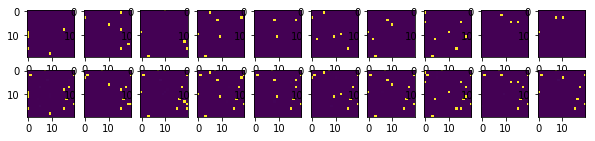

In [171]:
# p,c = run_DEC(np.array([[1,2],[1,3],[5,6],[6,6]]), np.array([0,0,1,1]), encoding='none')

p,c = run_DEC(simX4[:1000], simY4[:1000], encoding='ae')

In [182]:
wrong = np.where(np.argmax(p[-1],axis=1)==simY4[:1000])[0]
wrong.shape

(379,)

In [187]:
c[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,